Facility Cost Analysis - National Heatmap
This notebook creates comprehensive heatmaps showing:
1. Total Facility Costs (Rent + Utilities)
2. Labor Costs
3. Transportation Costs
4. Combined Cost Index

# Import Required Libraries

In [10]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import HeatMap
from branca.colormap import LinearColormap
%matplotlib inline

# Load and Prepare Data

In [11]:
# Load all datasets
demand_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data/demand.csv')
products_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data/products.csv') # pd.read_csv('Assignment Files/Data/products.csv')
stores_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//stores.csv')
rates_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//rates.csv')
labor_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//labor_cost.csv')
facilities_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//facilities.csv')


# Calculate total facility cost per square foot
facilities_df['Total_Cost_SqFt'] = facilities_df['RentCost_SqFt'] + facilities_df['UtilitiesOpsCost_SqFt']

# Create Cost Heatmap Function

In [12]:
def create_cost_heatmap(title, locations, values, save_name):
    """Create a folium map with cost heatmap"""
    m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
    
    # Create heatmap layer
    HeatMap(
        list(zip(
            [loc[0] for loc in locations],
            [loc[1] for loc in locations],
            values
        )),
        radius=35
    ).add_to(m)
    
    # Add title
    title_html = f'''
        <div style="position: fixed; 
                    top: 10px; 
                    left: 50px; 
                    width: 300px; 
                    height: 30px; 
                    z-index:9999; 
                    background-color: white; 
                    font-size: 16px; 
                    font-weight: bold;
                    padding: 5px;
                    border-radius: 5px;">
            {title}
        </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    return m

# Generate Facility Cost Heatmap

In [13]:
# Prepare facility cost data
facility_locations = []
facility_costs = []

for _, facility in facilities_df.iterrows():
    city = facility['Location'].split(',')[0].strip()
    state = facility['Location'].split(',')[1].strip()
    matching_stores = stores_df[
        (stores_df['City'] == city) & 
        (stores_df['State'] == state)
    ]
    
    if len(matching_stores) > 0:
        facility_locations.append([
            matching_stores.iloc[0]['Latitude'],
            matching_stores.iloc[0]['Longitude']
        ])
        facility_costs.append(facility['Total_Cost_SqFt'])

# Create facility cost heatmap
facility_cost_map = create_cost_heatmap(
    'Total Facility Cost per Square Foot ($)',
    facility_locations,
    facility_costs,
    'facility_cost_heatmap.html'
)
display(facility_cost_map)

# Generate Labor Cost Heatmap

In [14]:
# Prepare labor cost data
labor_locations = []
labor_costs = []

for _, labor in labor_df.iterrows():
    city = labor['Location'].split(',')[0].strip()
    state = labor['Location'].split(',')[1].strip()
    matching_stores = stores_df[
        (stores_df['City'] == city) & 
        (stores_df['State'] == state)
    ]
    
    if len(matching_stores) > 0:
        labor_locations.append([
            matching_stores.iloc[0]['Latitude'],
            matching_stores.iloc[0]['Longitude']
        ])
        labor_costs.append(labor['Local Labor Cost (USD/hour)'])

# Create labor cost heatmap
labor_cost_map = create_cost_heatmap(
    'Local Labor Cost ($/hour)',
    labor_locations,
    labor_costs,
    'labor_cost_heatmap.html'
)
display(labor_cost_map)

# Generate Transportation Cost Heatmap

In [15]:
def calculate_avg_transport_cost(origin):
    """Calculate average transportation cost per mile from an origin"""
    origin_rates = rates_df[rates_df['Origin'] == origin]
    if len(origin_rates) == 0:
        return None
    
    # Assume 26 pallets per truck for FTL
    return origin_rates['Cost_FTL'].mean() / 26

# Prepare transportation cost data
transport_locations = []
transport_costs = []

for origin in rates_df['Origin'].unique():
    city = origin.split(',')[0].strip()
    state = origin.split(',')[1].strip()
    matching_stores = stores_df[
        (stores_df['City'] == city) & 
        (stores_df['State'] == state)
    ]
    
    avg_cost = calculate_avg_transport_cost(origin)
    if len(matching_stores) > 0 and avg_cost is not None:
        transport_locations.append([
            matching_stores.iloc[0]['Latitude'],
            matching_stores.iloc[0]['Longitude']
        ])
        transport_costs.append(avg_cost)

transport_cost_map = create_cost_heatmap(
    'Transportation Cost ($/pallet)',
    transport_locations,
    transport_costs,
    'transport_cost_heatmap.html'
)
display(transport_cost_map)

# Create Combined Cost Index Map

In [16]:
def normalize_values(values):
    """Normalize values to 0-1 range"""
    min_val = min(values)
    max_val = max(values)
    return [(v - min_val) / (max_val - min_val) for v in values]

def create_combined_cost_map():
    """Create a map showing combined cost index"""
    m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
    
    # Get all unique locations
    all_locations = set()
    location_data = {}
    
    # Process facility costs
    for loc, cost in zip(facility_locations, normalize_values(facility_costs)):
        loc_key = f"{loc[0]},{loc[1]}"
        all_locations.add(loc_key)
        if loc_key not in location_data:
            location_data[loc_key] = {'loc': loc, 'costs': [], 'facility_cost': cost}
        location_data[loc_key]['costs'].append(cost)
    
    # Process labor costs
    for loc, cost in zip(labor_locations, normalize_values(labor_costs)):
        loc_key = f"{loc[0]},{loc[1]}"
        all_locations.add(loc_key)
        if loc_key not in location_data:
            location_data[loc_key] = {'loc': loc, 'costs': [], 'labor_cost': cost}
        location_data[loc_key]['costs'].append(cost)
    
    # Process transport costs
    for loc, cost in zip(transport_locations, normalize_values(transport_costs)):
        loc_key = f"{loc[0]},{loc[1]}"
        all_locations.add(loc_key)
        if loc_key not in location_data:
            location_data[loc_key] = {'loc': loc, 'costs': [], 'transport_cost': cost}
        location_data[loc_key]['costs'].append(cost)
    
    # Calculate combined index and prepare DataFrame
    combined_data = []
    for loc_key, data in location_data.items():
        avg_cost = np.mean(data['costs'])
        # Find the facility name for this location
        facility_name = None
        for _, facility in facilities_df.iterrows():
            city = facility['Location'].split(',')[0].strip()
            state = facility['Location'].split(',')[1].strip()
            matching_stores = stores_df[
                (stores_df['City'] == city) & 
                (stores_df['State'] == state)
            ]
            if len(matching_stores) > 0:
                store_loc = f"{matching_stores.iloc[0]['Latitude']},{matching_stores.iloc[0]['Longitude']}"
                if store_loc == loc_key:
                    facility_name = facility['Location']
                    break
        
        if facility_name:
            combined_data.append({
                'Location': facility_name,
                'Combined_Index': avg_cost,
                'Facility_Cost': data.get('facility_cost', np.nan),
                'Labor_Cost': data.get('labor_cost', np.nan),
                'Transport_Cost': data.get('transport_cost', np.nan)
            })
            
            # Add marker with detailed information
            folium.CircleMarker(
                location=data['loc'],
                radius=8,
                color='purple',
                fill=True,
                popup=f"Location: {facility_name}<br>" +
                      f"Combined Index: {avg_cost:.3f}",
                fillOpacity=0.7
            ).add_to(m)
    
    # Create and sort DataFrame
    combined_df = pd.DataFrame(combined_data)
    combined_df = combined_df.sort_values('Combined_Index')
    
    # Add heatmap layer
    heat_data = [[data['loc'][0], data['loc'][1], np.mean(data['costs'])] 
                 for data in location_data.values()]
    HeatMap(heat_data, radius=35).add_to(m)
    
    return m, combined_df

In [17]:
# Create and display combined cost map and table
combined_map, combined_df = create_combined_cost_map()
print("\nCombined Cost Index Analysis (Sorted from Lowest to Highest):")
display(combined_df)
display(combined_map)


Combined Cost Index Analysis (Sorted from Lowest to Highest):


,Location,Combined_Index,Facility_Cost,Labor_Cost,Transport_Cost
2,"Austin, TX",0.107034,0.116208,NaN,NaN
1,"Memphis, TN",0.111489,0.000000,NaN,NaN
9,"Houston, TX",0.166064,0.012232,NaN,NaN
13,"San Antonio, TX",0.171303,0.281346,NaN,NaN
17,"Dallas, TX",0.195993,0.296636,NaN,NaN
23,"Milwaukee, WI",0.218955,0.039755,NaN,NaN
8,"Louisville, KY",0.236823,0.103976,NaN,NaN
11,"Nashville, TN",0.243841,0.229358,NaN,NaN
24,"Kansas City, MO",0.245247,0.070336,NaN,NaN
15,"Phoenix, AZ",0.247008,0.085627,NaN,NaN


# Cost Distribution Analysis

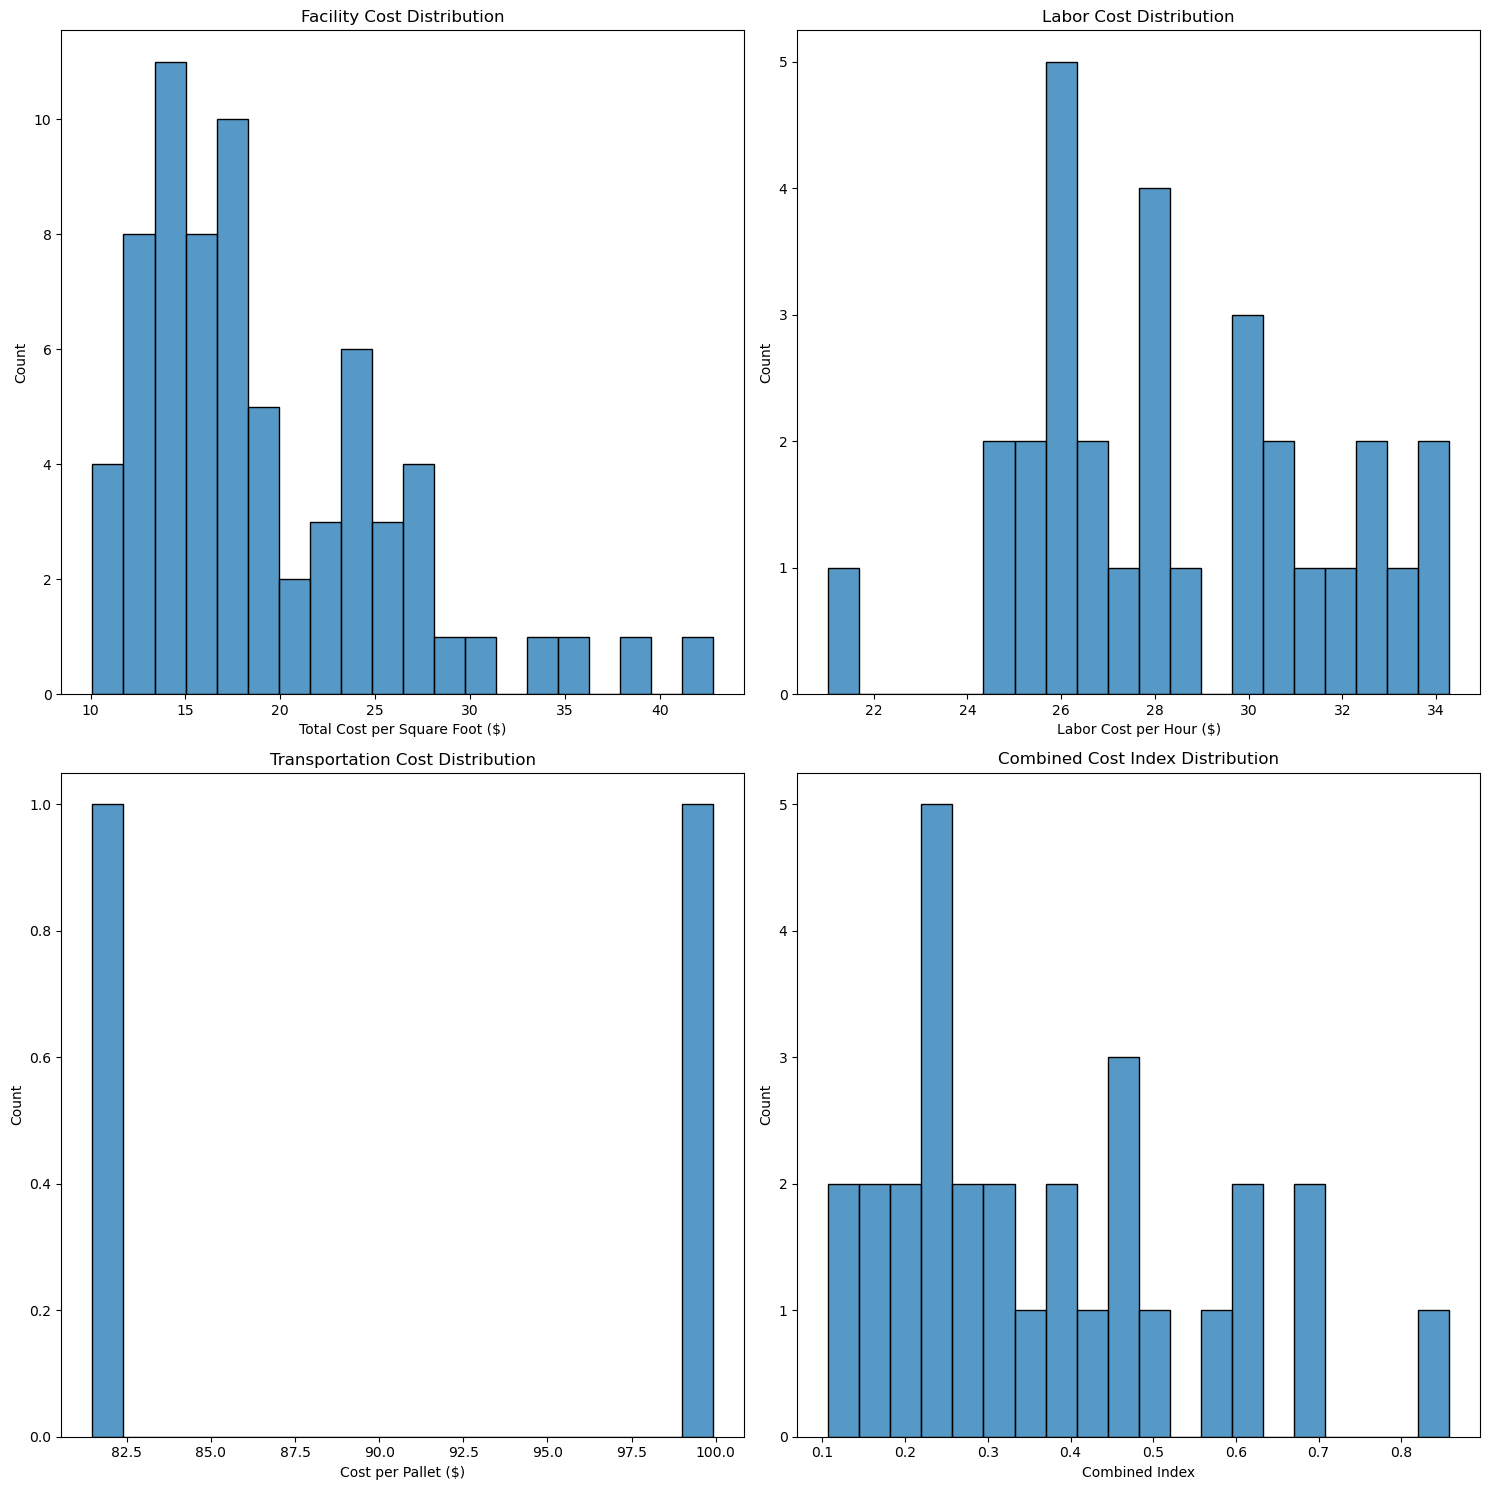

In [18]:
# Create distribution plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Facility Cost Distribution
sns.histplot(data=facilities_df, x='Total_Cost_SqFt', bins=20, ax=ax1)
ax1.set_title('Facility Cost Distribution')
ax1.set_xlabel('Total Cost per Square Foot ($)')
ax1.set_ylabel('Count')

# Labor Cost Distribution
sns.histplot(data=labor_df, x='Local Labor Cost (USD/hour)', bins=20, ax=ax2)
ax2.set_title('Labor Cost Distribution')
ax2.set_xlabel('Labor Cost per Hour ($)')
ax2.set_ylabel('Count')

# Transportation Cost Distribution
transport_costs_df = pd.DataFrame({
    'Cost_Per_Pallet': transport_costs
})
sns.histplot(data=transport_costs_df, x='Cost_Per_Pallet', bins=20, ax=ax3)
ax3.set_title('Transportation Cost Distribution')
ax3.set_xlabel('Cost per Pallet ($)')
ax3.set_ylabel('Count')

# Combined Index Distribution
sns.histplot(data=combined_df, x='Combined_Index', bins=20, ax=ax4)
ax4.set_title('Combined Cost Index Distribution')
ax4.set_xlabel('Combined Index')
ax4.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Key Findings

1. Facility Costs:
   - Highest in coastal areas (especially West Coast)
   - Lowest in central regions
   - Significant variation between urban and rural areas

2. Labor Costs:
   - Follow similar patterns to facility costs
   - Higher in major metropolitan areas
   - More uniform in central regions

3. Transportation Costs:
   - Lower in areas with good infrastructure
   - Higher in remote locations
   - Significant impact of distance to major markets

4. Combined Cost Index:
   - Identifies optimal regions balancing all cost factors
   - Shows clear cost advantages in certain geographic areas
   - Top 5 lowest-cost locations: {', '.join(combined_df.head(5)['Location'].tolist())}